In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the LDA and CTM results
lda_results_df = pd.read_pickle('saved_models/lda_model_results_summary.pkl')
ctm_results_df = pd.read_pickle('saved_models/ctm_model_results_summary.pkl')

In [13]:
# Remove all rows with 5 topics from the LDA DataFrame
lda_results_df = lda_results_df[lda_results_df['num_topics'] != 5]

# Extract data for LDA
lda_num_topics = lda_results_df['num_topics']
lda_coherence_scores = lda_results_df['coherence_score']
lda_topic_diversity = lda_results_df.get('topic_diversity', None)

# Extract data for CTM
ctm_num_topics = ctm_results_df['num_topics']
ctm_coherence_scores = ctm_results_df['coherence_score']
ctm_topic_diversity = ctm_results_df.get('topic_diversity', None)

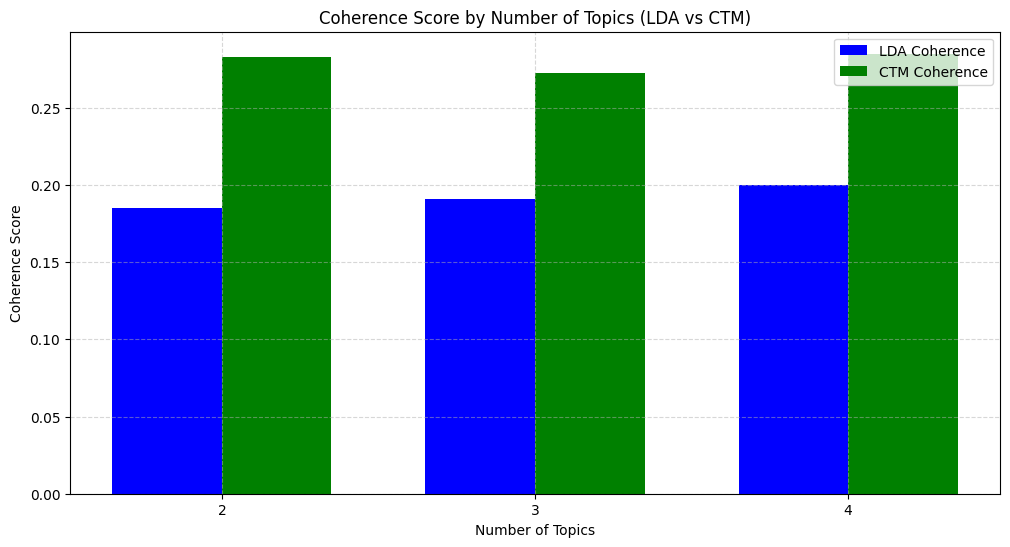

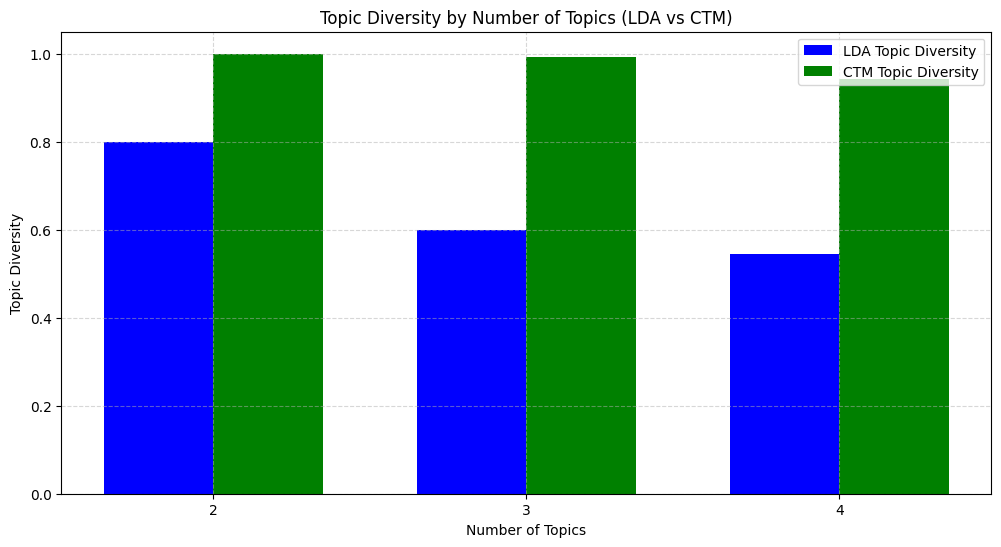

In [15]:
# Coherence Score Bar Plot
# Prepare the data for plotting coherence scores
unique_topics_lda = lda_results_df['num_topics'].unique()
unique_topics_ctm = ctm_results_df['num_topics'].unique()
unique_topics = sorted(set(unique_topics_lda) | set(unique_topics_ctm))  # Sorted unique topics

lda_coherence_means = [
    lda_results_df[lda_results_df['num_topics'] == num]['coherence_score'].mean() if num in unique_topics_lda else np.nan
    for num in unique_topics
]
ctm_coherence_means = [
    ctm_results_df[ctm_results_df['num_topics'] == num]['coherence_score'].mean() if num in unique_topics_ctm else np.nan
    for num in unique_topics
]

x = np.arange(len(unique_topics))  # the label locations
width = 0.35  # the width of the bars

# Plot Coherence Score
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, lda_coherence_means, width, label='LDA Coherence', color='b')
bars2 = ax.bar(x + width/2, ctm_coherence_means, width, label='CTM Coherence', color='g')

# Add labels, title, and legend
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_title('Coherence Score by Number of Topics (LDA vs CTM)')
ax.set_xticks(x)
ax.set_xticklabels(unique_topics)
ax.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Topic Diversity Bar Plot (if available for both LDA and CTM)
if lda_topic_diversity is not None and ctm_topic_diversity is not None:
    lda_diversity_means = [
        lda_results_df[lda_results_df['num_topics'] == num]['topic_diversity'].mean() if num in unique_topics_lda else np.nan
        for num in unique_topics
    ]
    ctm_diversity_means = [
        ctm_results_df[ctm_results_df['num_topics'] == num]['topic_diversity'].mean() if num in unique_topics_ctm else np.nan
        for num in unique_topics
    ]

    # Plot Topic Diversity
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, lda_diversity_means, width, label='LDA Topic Diversity', color='b')
    bars2 = ax.bar(x + width/2, ctm_diversity_means, width, label='CTM Topic Diversity', color='g')

    # Add labels, title, and legend
    ax.set_xlabel('Number of Topics')
    ax.set_ylabel('Topic Diversity')
    ax.set_title('Topic Diversity by Number of Topics (LDA vs CTM)')
    ax.set_xticks(x)
    ax.set_xticklabels(unique_topics)
    ax.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [16]:
lda_results_df_sorted = lda_results_df.sort_values(by='coherence_score', ascending=False)
ctm_results_df_sorted = ctm_results_df.sort_values(by='coherence_score', ascending=False)
best_lda_params = lda_results_df_sorted.iloc[0]
best_ctm_params = ctm_results_df_sorted.iloc[0]
print("Best LDA Model Parameters:")
print(best_lda_params)

print("\nBest CTM Model Parameters:")
print(best_ctm_params)

Best LDA Model Parameters:
model_id                103
num_topics                4
alpha                  auto
beta                    0.1
passes                   20
iterations              100
coherence_score    0.205612
topic_diversity        0.55
Name: 28, dtype: object

Best CTM Model Parameters:
model_id           15.000000
num_topics          2.000000
epochs             20.000000
learning_rate       0.005000
batch_size         64.000000
coherence_score     0.344318
topic_diversity     1.000000
Name: 2, dtype: float64


In [17]:
from gensim.models import LdaModel
from contextualized_topic_models.models.ctm import CombinedTM
import importlib
import utility_functions as utils
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from gensim import corpora
importlib.reload(utils)

<module 'utility_functions' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/utility_functions.py'>

In [18]:
# Load your dataframe
df = pd.read_pickle('./preprocessed_df.pkl')

if isinstance(df['Tokens'].iloc[0], str):
    import ast
    df['Tokens'] = df['Tokens'].apply(ast.literal_eval)

texts = df['Tokens']
texts_bow = [' '.join(tokens) for tokens in df['Tokens']]
dictionary = corpora.Dictionary(df['Tokens'])
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]
df['Lyrics'] = df['Lyrics'].apply(utils.light_preprocessing)
documents = df['Lyrics']

In [19]:
tp = TopicModelDataPreparation("all-mpnet-base-v2", max_seq_length=512)
training_dataset = tp.fit(text_for_contextual=documents, text_for_bow=texts_bow)

/Users/borosabel/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 1919 words, the model instead truncates to 512 tokens.
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
dictionary = corpora.Dictionary(texts)

In [21]:
# Retrain the best LDA model
best_lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=int(best_lda_params['num_topics']),
    alpha=best_lda_params['alpha'],
    eta=float(best_lda_params['beta']),
    passes=int(best_lda_params['passes']),
    iterations=int(best_lda_params['iterations']),
    random_state=42
)

best_ctm_model = CombinedTM(
    bow_size=len(tp.vocab),
    contextual_size=768,
    n_components=int(best_ctm_params['num_topics']),
    num_epochs=int(best_ctm_params['epochs']),
    batch_size=int(best_ctm_params['batch_size']),
    activation='softplus',
    dropout=0.2,
    solver='adam',
    num_data_loader_workers=0,
)

# Train the model with the training dataset
best_ctm_model.fit(training_dataset)

Epoch: [20/20]	 Seen Samples: [26880/27360]	Train Loss: 1201.9247465587798	Time: 0:00:00.181669: : 20it [00:03,  5.06it/s]
100%|██████████| 22/22 [00:00<00:00, 184.76it/s]


In [22]:
# Extract topics from LDA
lda_topics = best_lda_model.show_topics(num_topics=int(best_lda_params['num_topics']), num_words=10, formatted=False)

# Extract topics from CTM
ctm_topics = best_ctm_model.get_topic_lists(10)

In [23]:
# Create DataFrame for LDA topics
lda_topic_df = pd.DataFrame({
    f'Topic {i+1}': [word for word, _ in topic_words]
    for i, (_, topic_words) in enumerate(lda_topics)
}).transpose()

# Create DataFrame for CTM topics (CTM topics is already in a list of lists format)
ctm_topic_df = pd.DataFrame({
    f'Topic {i+1}': topic
    for i, topic in enumerate(ctm_topics)
}).transpose()

# Display the DataFrames for verification
print("LDA Topics DataFrame:")
print(lda_topic_df)

print("\nCTM Topics DataFrame:")
print(ctm_topic_df)

LDA Topics DataFrame:
             0      1      2             3     4     5     6     7     8  \
Topic 1     go   know  rhyme          make  come   let   say   man  back   
Topic 2  nigga   fuck   shit  motherfucker   ass    go  know  come  back   
Topic 3  nigga  bitch   know          fuck  want  shit  make    go   see   
Topic 4    one   know     go          time   man  love  come   see  live   

             9  
Topic 1   want  
Topic 2  bitch  
Topic 3   back  
Topic 4  would  

CTM Topics DataFrame:
             0     1             2        3     4       5     6       7  \
Topic 1    ice  gear          glad  shoulda  bull  weight   wax   level   
Topic 2  nigga  fuck  motherfucker       us  know   bitch  shit  police   

             8     9  
Topic 1  pants  foot  
Topic 2   bout    go  
